<a href="https://colab.research.google.com/github/AUT-Student/BigData-HW2/blob/main/BigData_HW2_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PySpark Setting

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 30 kB/s 
     |████████████████████████████████| 198 kB 39.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=f117b6dfe26fc7ecba66a869c9f48bf1acbb9d1b48b74aa87f51faffe12868b7
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [3]:
spark

# Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from pyspark.sql.types import FloatType, ArrayType, IntegerType
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
from pyspark.sql import Window

# Dataset

In [6]:
!gdown 1PdXgb4w0gtsocKHmeGQ_zPfb3VbW9YhL
!unzip /content/Bigdata_hw2_datasets.zip

Downloading...
From: https://drive.google.com/uc?id=1PdXgb4w0gtsocKHmeGQ_zPfb3VbW9YhL
To: /content/Bigdata_hw2_datasets.zip
100% 6.28M/6.28M [00:00<00:00, 36.7MB/s]
Archive:  /content/Bigdata_hw2_datasets.zip
   creating: Bigdata_hw2_datasets/
   creating: Bigdata_hw2_datasets/q1/
  inflating: Bigdata_hw2_datasets/q1/stream_data_dgim.txt  
   creating: Bigdata_hw2_datasets/q2/
  inflating: Bigdata_hw2_datasets/q2/games.csv  
  inflating: Bigdata_hw2_datasets/q2/ratings.csv  
   creating: Bigdata_hw2_datasets/q3/
  inflating: Bigdata_hw2_datasets/q3/c1.txt  
  inflating: Bigdata_hw2_datasets/q3/c2.txt  
  inflating: Bigdata_hw2_datasets/q3/data.txt  


In [7]:
dataset_pandas = pd.read_csv("/content/Bigdata_hw2_datasets/q3/data.txt", header=None, names=["data"])
dataset_pandas["data"] = dataset_pandas["data"].apply(lambda x:x.split(" "))
dataset_pandas["data"] = dataset_pandas["data"].apply(lambda item: [float(x) for x in item])
dataset_pandas["data-id"] = range(len(dataset_pandas))

c1_pandas = pd.read_csv("/content/Bigdata_hw2_datasets/q3/c1.txt", header=None, names=["center"])
c1_pandas["center"] = c1_pandas["center"].apply(lambda x:x.split(" "))
c1_pandas["center"] = c1_pandas["center"].apply(lambda item: [float(x) for x in item])
c1_pandas["center-id"] = range(len(c1_pandas))

c2_pandas = pd.read_csv("/content/Bigdata_hw2_datasets/q3/c2.txt", header=None, names=["center"])
c2_pandas["center"] = c2_pandas["center"].apply(lambda x:x.split(" "))
c2_pandas["center"] = c2_pandas["center"].apply(lambda item: [float(x) for x in item])
c2_pandas["center-id"] = range(len(c2_pandas))

In [8]:
NUMBER_FEATURES = 58

# KMeans

In [12]:
class SparkKMeans():
  def __init__(self, dataset, center, description, distance_metric_name):
    self.dataset_spark = spark.createDataFrame(dataset)
    self.center_spark = spark.createDataFrame(center)
    self.description = description

    if distance_metric_name == "Euclidean":
      self.distance_metric = self.euclidean_distance
    elif distance_metric_name == "Manhatan":
      self.distance_metric = self.manhatan_distance
    else:
      raise Exception("Invalid distance_metric_name!")

  def run(self, number_epochs):
    self.number_epochs = number_epochs
    self.costs = []
    for step in range(number_epochs):
      data_center_spark = self.dataset_spark.join(self.center_spark)\
                              .withColumn('distance', self.distance_metric(self.dataset_spark.data, self.center_spark.center))

      data_center_spark = data_center_spark.withColumn("min-distance", f.min("distance")\
                                           .over(Window.partitionBy("data-id")))\
                                           .where(f.col("min-distance") == f.col("distance"))\
                                           .drop(*["min-distance", "center"])

      step_cost = data_center_spark.select("distance")\
                                   .groupBy().sum().collect()[0][0]
      
      self.costs.append(step_cost)
      print(f"Step = {step}, Cost = {step_cost}")

      data_center_mapping = data_center_spark.drop(*["data", "distance"])\
                                             .toDF("data-id", "center-id")\
                                             .toPandas()
      
      data_center_spark = data_center_spark.groupBy("center-id")\
                                           .agg(f.collect_list("data")\
                                           .alias("data-list"))

      array_mean_udf = udf(self.array_mean, ArrayType(FloatType()))

      self.center_spark = data_center_spark.select("center-id", array_mean_udf("data-list")\
                                           .alias("center"))

    return data_center_mapping

  def report(self):
    print(f"Change cost percent in ten steps {int((self.costs[0] - self.costs[10]) / self.costs[0] * 100)}%\n") 

    plt.scatter(range(1, self.number_epochs+1), self.costs)
    plt.plot(range(1, self.number_epochs+1), self.costs)
    plt.xlabel("Step")
    plt.ylabel("Cost")
    plt.title(f"Change Cost in KMeans\n{self.description}")
    plt.show()

  @staticmethod
  def euclidean_distance(a, b):
    distance = 0
    for i in range(NUMBER_FEATURES):
      distance += (a[i] - b[i]) ** 2
    return distance ** 0.5

  @staticmethod
  def manhatan_distance(a, b):
    distance = 0
    for i in range(NUMBER_FEATURES):
      distance += f.abs(a[i] - b[i])
    return distance

  @staticmethod
  def array_mean(x):
    number_data = len([i for i in zip(*x)][0])
    sum_array = [sum(i) for i in zip(*x)]
    return [item/number_data for item in sum_array]

# Results

Distance Metric = Euclidean | Center Name = C1
Step = 0, Cost = 395749.8468388532
Step = 1, Cost = 318949.51101113483
Step = 2, Cost = 316897.8071501825
Step = 3, Cost = 327978.22519918176
Step = 4, Cost = 333528.0769713639
Step = 5, Cost = 334334.41537335224
Step = 6, Cost = 334093.90368501254
Step = 7, Cost = 333273.4312510706
Step = 8, Cost = 331554.1755801971
Step = 9, Cost = 329840.47699853603
Step = 10, Cost = 328722.7106742206
Step = 11, Cost = 328750.6934242609
Step = 12, Cost = 329348.7148805231
Step = 13, Cost = 329348.8991447655
Step = 14, Cost = 329282.30882074387
Step = 15, Cost = 329642.62883340573
Step = 16, Cost = 329593.37367925036
Step = 17, Cost = 329459.8591616328
Step = 18, Cost = 329719.50750799815
Step = 19, Cost = 330176.9366961528
Change cost percent in ten steps 16%



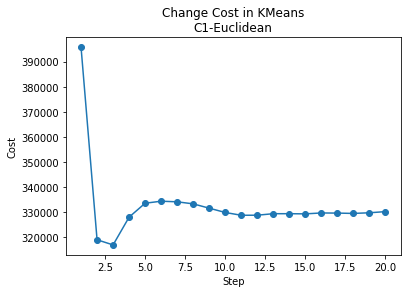

Distance Metric = Euclidean | Center Name = C2
Step = 0, Cost = 1150355.5436059786
Step = 1, Cost = 825718.3815378408
Step = 2, Cost = 708799.3820943746
Step = 3, Cost = 657164.9968611912
Step = 4, Cost = 625836.6047303933
Step = 5, Cost = 607124.6611016592
Step = 6, Cost = 589221.9843275077
Step = 7, Cost = 568010.6121654253
Step = 8, Cost = 539364.637782208
Step = 9, Cost = 515826.6172109743
Step = 10, Cost = 498616.298471274
Step = 11, Cost = 484873.4854135511
Step = 12, Cost = 474576.71495498193
Step = 13, Cost = 466189.7460151896
Step = 14, Cost = 459349.7074162843
Step = 15, Cost = 453778.7245210844
Step = 16, Cost = 449818.2257010622
Step = 17, Cost = 446966.3756914019
Step = 18, Cost = 444163.5018917574
Step = 19, Cost = 441696.6980722874
Change cost percent in ten steps 56%



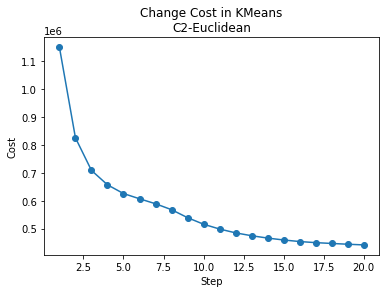

Distance Metric = Manhatan | Center Name = C1
Step = 0, Cost = 565475.4720000032
Step = 1, Cost = 466514.2971280042
Step = 2, Cost = 470857.75163717516
Step = 3, Cost = 483869.30878529814
Step = 4, Cost = 489200.84700234374
Step = 5, Cost = 487576.0291287648
Step = 6, Cost = 483583.2481417699
Step = 7, Cost = 475324.8079596467
Step = 8, Cost = 474856.0566063218
Step = 9, Cost = 457207.7554022045
Step = 10, Cost = 447505.25173996756
Step = 11, Cost = 450946.12209732604
Step = 12, Cost = 451237.9370883775
Step = 13, Cost = 451958.97678462823
Step = 14, Cost = 451570.36446897686
Step = 15, Cost = 452739.01060344203
Step = 16, Cost = 453082.7303367916
Step = 17, Cost = 450583.67023330537
Step = 18, Cost = 450368.7457612367
Step = 19, Cost = 449011.3633032016
Change cost percent in ten steps 20%



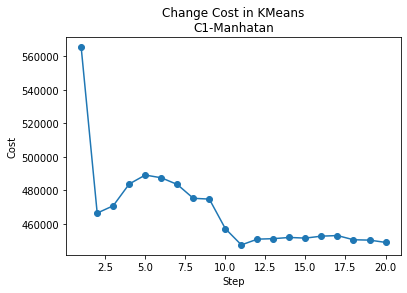

Distance Metric = Manhatan | Center Name = C2
Step = 0, Cost = 1433739.3099999938
Step = 1, Cost = 1084488.7693964501
Step = 2, Cost = 973431.7202677557
Step = 3, Cost = 895934.5987381018
Step = 4, Cost = 865128.3216957817
Step = 5, Cost = 845846.65922853
Step = 6, Cost = 827219.5871540306
Step = 7, Cost = 803590.3411259102
Step = 8, Cost = 756039.519582125
Step = 9, Cost = 717332.9004420241
Step = 10, Cost = 694587.9250391687
Step = 11, Cost = 684444.498730303
Step = 12, Cost = 674574.7499253174
Step = 13, Cost = 667409.4706312704
Step = 14, Cost = 663556.6249497061
Step = 15, Cost = 660162.7754313725
Step = 16, Cost = 656041.3237065368
Step = 17, Cost = 653036.7599125181
Step = 18, Cost = 651112.4272994011
Step = 19, Cost = 649689.017906071
Change cost percent in ten steps 51%



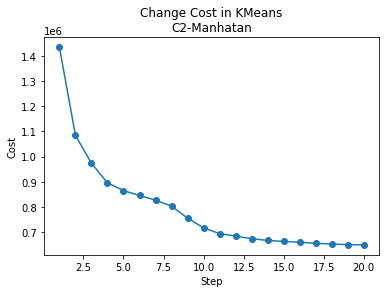

In [13]:
for distance_metric_name in ["Euclidean", "Manhatan"]:
  for center, center_name in [(c1_pandas, "C1"), (c2_pandas, "C2")]:
    print(f"Distance Metric = {distance_metric_name} | Center Name = {center_name}")

    kmeans = SparkKMeans(dataset=dataset_pandas, center=center, description=f"{center_name}-{distance_metric_name}", distance_metric_name=distance_metric_name)

    kmeans_output = kmeans.run(number_epochs=20)

    kmeans.report()    